In [2]:
import pandas as pd
from konlpy.tag import Mecab
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os
import re

In [3]:
train_data = pd.read_csv('ratings_train.txt', sep = "\t", engine='python')
test_data = pd.read_csv('ratings_test.txt', sep = "\t", engine='python')

In [4]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [5]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [6]:
tokenizer = Mecab()
tokenized_sentence = tokenizer.morphs('뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아')
#morphs는 형태소 추출 (+nouns: 명사추출, pos: 품사 부착)
tokenized_sentence

['뭐',
 '야',
 '이',
 '평점',
 '들',
 '은',
 '.',
 '...',
 '나쁘',
 '진',
 '않',
 '지만',
 '10',
 '점',
 '짜리',
 '는',
 '더더욱',
 '아니',
 '잖아']

In [7]:
def preprocess_review(sentence):
    sentence = re.sub(r'\([^)]*\)',r'',sentence) #소괄호 내용 삭제
    sentence = re.sub(r'\[[^)]*\]',r'',sentence) #대괄호 내용 삭제
    
    sentence = re.sub(r'["."]{2,}', r" .. ", sentence)#두 개이상의 .을 ..으로 변환
    sentence = re.sub(r'["?"]{2,}', r" ?? ", sentence)#두 개이상의 ?을 ??으로 변환
    sentence = re.sub(r'["!"]{2,}', r" !! ", sentence)#두 개이상의 !을 !!으로 변환
    sentence = re.sub(r'["ㅜ"]{2,}', r" ㅜㅜ ", sentence)#두 개이상의 자음을 2번 반복으로 변환
    sentence = re.sub(r'["ㅠ"]{2,}', r" ㅠㅠ ", sentence)
    sentence = re.sub(r'["ㅋ"]{2,}', r" ㅋㅋ ", sentence)
    sentence = re.sub(r'["ㅎ"]{2,}', r" ㅎㅎ ", sentence)
    sentence = re.sub(r'["ㄱ"]{2,}', r" ㄱㄱ ", sentence)
    sentence = re.sub(r'["ㄷ"]{2,}', r" ㄷㄷ ", sentence)
    sentence = re.sub(r'["ㅅ"]{2,}', r" ㅅㅅ ", sentence)
    sentence = re.sub(r'["ㅊ"]{2,}', r" ㅊㅊ ", sentence)

    sentence = re.sub(r'["ㅈㄴ"]+',"", sentence)
    sentence = re.sub(r'["ㅅㅂ"]+',"", sentence)
    
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣.?!,' ]+","",sentence) #한글 및 지정된 특수문자 외 제거
    sentence = re.sub(r'[" "]+'," ",sentence) #연속된 공백은 공백 하나로 처리
    
    return sentence

In [8]:
 preprocess_review('아..........ㅈㄴ       머냐 정말!@#')

'아 .. 머냐 정말!'

In [9]:
stopwords = ['의','가','이','은', '을','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', '겠', '음']

In [10]:
def load_data(train_data, test_data, num_words = 10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data['document'] = train_data['document'].apply(lambda x: preprocess_review(str(x)))
    train_data = train_data.dropna(how = 'any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data['document'] = test_data['document'].apply(lambda x: preprocess_review(str(x)))
    test_data = test_data.dropna(how = 'any')
    
    X_train = []
    for sentence in train_data['document']:
     temp_X = tokenizer.morphs(sentence) #토큰화
     temp_X = [word for word in temp_X if not word in stopwords] 
     X_train.append(temp_X)
    
    X_test = []
    for sentence in test_data['document']:
     temp_X = tokenizer.morphs(sentence) #토큰화
     temp_X = [word for word in temp_X if not word in stopwords] 
     X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>','<BOS>','<UNK>','<UNUSED>'] + [key for key, _ in counter]#특수한 토큰에 대해 지정
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>']for word in wordlist]
        #사전에 없는 단어에는 <unk>토큰을 부여
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

#X_train, X_test 각 문장이 형태소별 빈도수로 인코딩된 list
#train_set, test_set의 label은 0,1로 이루어진 np.array

In [11]:
X_train, y_train, X_test, y_test, word_dict = load_data(train_data, test_data)

In [12]:
word_dict #사전의 앞부분

{'<PAD>': 0,
 '<BOS>': 1,
 '<UNK>': 2,
 '<UNUSED>': 3,
 '.': 4,
 '영화': 5,
 '다': 6,
 '고': 7,
 '하': 8,
 '보': 9,
 '!': 10,
 ',': 11,
 '게': 12,
 '지': 13,
 '있': 14,
 '?': 15,
 '없': 16,
 '좋': 17,
 '나': 18,
 '었': 19,
 '만': 20,
 '는데': 21,
 '너무': 22,
 '봤': 23,
 '적': 24,
 '안': 25,
 '로': 26,
 '정말': 27,
 '것': 28,
 '아': 29,
 'ㅋㅋ': 30,
 '네요': 31,
 '어': 32,
 '재밌': 33,
 '같': 34,
 '지만': 35,
 '진짜': 36,
 '했': 37,
 '기': 38,
 '에서': 39,
 '네': 40,
 '점': 41,
 '않': 42,
 '거': 43,
 '았': 44,
 '수': 45,
 '되': 46,
 '면': 47,
 '말': 48,
 '인': 49,
 '연기': 50,
 '주': 51,
 '최고': 52,
 '내': 53,
 '평점': 54,
 '이런': 55,
 '던': 56,
 '어요': 57,
 '할': 58,
 '왜': 59,
 '해': 60,
 '스토리': 61,
 '습니다': 62,
 '드라마': 63,
 '아니': 64,
 '생각': 65,
 '더': 66,
 '그': 67,
 '싶': 68,
 '사람': 69,
 '듯': 70,
 '때': 71,
 '감동': 72,
 '함': 73,
 '배우': 74,
 '본': 75,
 '까지': 76,
 '뭐': 77,
 '보다': 78,
 '알': 79,
 '만들': 80,
 '내용': 81,
 '볼': 82,
 '감독': 83,
 '라': 84,
 '그냥': 85,
 '재미': 86,
 '시간': 87,
 '지루': 88,
 '재미있': 89,
 '중': 90,
 '였': 91,
 '년': 92,
 '잼': 93,
 '사랑': 94,
 '못

In [13]:
#문장의 정수인코딩 변호나을 확인하는 작업
z = train_data['document'].iloc[8300]
z

'ㅎ나름 볼만 했어요'

In [14]:
tokenizer.morphs(z)

['ㅎ', '나름', '볼', '만', '했어요']

In [15]:
#padding

total_data_text = list(X_train) + list(X_test)
#텍스트 데이터 문장길이의 리스트를 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
#문자길이의 평균, 최대, 표준편차 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

#예시로 최대 길이를 '평균+2.2*표준편차'로 가정
max_tokens = np.mean(num_tokens)+2.2*np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {:.2f}%가 maxlen 설정값 이내에 포함됩니다. ' \
     .format(100 * np.sum(num_tokens < max_tokens)/len(num_tokens))) 

문장길이 평균 :  15.151417265192663
문장길이 최대 :  90
문장길이 표준편차 :  12.285869297870217
pad_sequences maxlen :  42
전체 문장의 94.40%가 maxlen 설정값 이내에 포함됩니다. 


In [16]:
import tensorflow as tf
from tensorflow import keras
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_dict["<PAD>"],
                                                        padding='pre', #of post
                                                        maxlen=maxlen)
X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                        value=word_dict["<PAD>"],
                                                        padding='pre', #of post
                                                        maxlen=maxlen)
print(X_train.shape)

(146183, 42)


In [17]:
X_train[8300]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,  287,  377,   82,   20, 2726], dtype=int32)

In [33]:
from sklearn.model_selection import train_test_split

import tensorflow_addons as tfa
from tensorflow.keras.initializers import Constant
from tensorflow.keras.regularizers import l2

#train_set 을 train과 val로 분해
X_train, X_trainval, y_train, y_trainval = train_test_split(
    X_train, y_train, test_size=0.25)

vocab_size = 10000 #vacab dict size(10,000개 단어)
word_vector_dim = 256

lnLSTMCell = tfa.rnn.LayerNormLSTMCell(256, recurrent_dropout=0.2, dropout=0.3, kernel_regularizer=l2(0.015), recurrent_regularizer=l2(0.015))
rnn = tf.keras.layers.RNN(lnLSTMCell, return_sequences=False, return_state=False)

#model 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(rnn)
model.add(keras.layers.Dense(15, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(keras.layers.Dense(1, activation='sigmoid')) #최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 256)         2560000   
_________________________________________________________________
rnn_2 (RNN)                  (None, 256)               529920    
_________________________________________________________________
dense_4 (Dense)              (None, 15)                3855      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 16        
Total params: 3,093,791
Trainable params: 3,093,791
Non-trainable params: 0
_________________________________________________________________


In [34]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min'),
             tf.keras.callbacks.ModelCheckpoint(filepath='biggr_model.h5',
                                                monitor='val_loss',
                                                save_best_only=True)]
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=15

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_trainval, y_trainval),
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/15
121/121 [==============================] - 34s 282ms/step - loss: 3.4254 - accuracy: 0.7285 - val_loss: 0.9025 - val_accuracy: 0.8164
Epoch 2/15
121/121 [==============================] - 34s 285ms/step - loss: 0.6902 - accuracy: 0.8414 - val_loss: 0.5501 - val_accuracy: 0.8314
Epoch 3/15
121/121 [==============================] - 33s 273ms/step - loss: 0.4479 - accuracy: 0.8634 - val_loss: 0.4938 - val_accuracy: 0.8333
Epoch 4/15
121/121 [==============================] - 34s 277ms/step - loss: 0.3783 - accuracy: 0.8764 - val_loss: 0.4433 - val_accuracy: 0.8288
Epoch 5/15
121/121 [==============================] - 33s 275ms/step - loss: 0.3545 - accuracy: 0.8841 - val_loss: 0.4806 - val_accuracy: 0.8402


In [35]:
#test_set 을 test과 val로 분해
X_test, X_testval, y_test, y_testval = train_test_split(X_test, y_test, test_size=0.25)


In [36]:
model.evaluate(X_testval, y_testval)

289/289 [==============================] - 7s 23ms/step - loss: 0.4961 - accuracy: 0.8314


[0.49612605571746826, 0.8313984870910645]

In [37]:
model.evaluate(X_test, y_test)

865/865 [==============================] - 20s 23ms/step - loss: 0.4891 - accuracy: 0.8349


[0.48910364508628845, 0.8349065184593201]

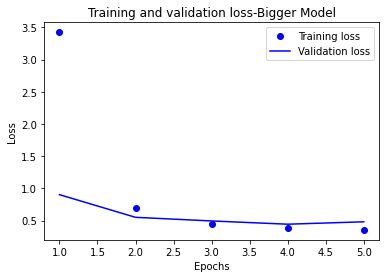

In [38]:
history_dict=history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
#bo는 점, b는 선
plt.plot(epochs, loss, 'bo',label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss-Bigger Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

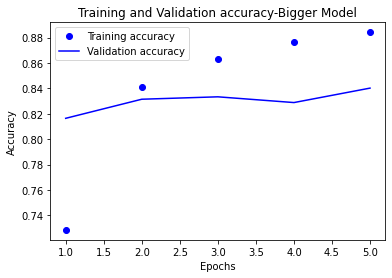

In [39]:
plt.clf() #초기화

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy-Bigger Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [40]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 256)


In [41]:
def encode_sentence(sentence_list):
    X=[]
    for sentence in sentence_list:
        sentence = preprocess_review(sentence) #전처리
        temp_X = tokenizer.morphs(sentence)#형태로 분리
        temp_X = [word for word in temp_X if not word in stopwords]#불용어 처리
        X.append(temp_X) #모으기
        
    encoded_sentences = list(map(wordlist_to_indexlist, X))#정수인코딩
    return encoded_sentences

def wordlist_to_indexlist(wordlist): #training에 사용한 '사전'을 word_dict자리에 넣음
    return [word_dict[word] if word in word_dict else word_dict['<UNK>'] for word in wordlist ]

In [42]:
def predict_sentence(sentence_list): #불러온 모델에 문장 리스트를 넣어 예측값을 이해하기 쉬운 형태로 출력
    encoded_list = encode_sentence(sentence_list)
    padded_list = tf.keras.preprocessing.sequence.pad_sequences(encoded_list,
                                                                value=word_dict["<PAD>"],
                                                                padding='pre', #혹은 'post',
                                                                maxlen=maxlen)
    score_list = model.predict(padded_list)
    for sentence, score in zip(sentence_list, score_list):
        if(score > 0.5):
            print(f"문장 : {sentence}\n {float(score) * 100:.2f}% 확률로 긍정 리뷰입니다. \n")
        else:
            print(f"문장 : {sentence}\n {float(score) * 100:.2f}% 확률로 부정 리뷰입니다. \n")

In [43]:
predict_sentence(['별 재미도없는거 우려먹어 .... 챔프에서 방송 몇번했더라 ? ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ','꽤 재밌게 본 영화였다!', '북괴는 우리의 주적일뿐이다' ])

문장 : 별 재미도없는거 우려먹어 .... 챔프에서 방송 몇번했더라 ? ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
 4.22% 확률로 부정 리뷰입니다. 

문장 : 꽤 재밌게 본 영화였다!
 98.13% 확률로 긍정 리뷰입니다. 

문장 : 북괴는 우리의 주적일뿐이다
 16.07% 확률로 부정 리뷰입니다. 



In [44]:
predict_sentence(['액션이 진짜 꽤 괜찮았다. ㅎ', '두말할필요없다 이건 보지마 시간이 남으면 집에서 발닦고 잠이나 자라', '한회 한회 보면서 총체적으로 발연기다. 중량급 연기자들도 모두 하향 평준화되는듯. 작가의 생각도 너무 어이업슴. 일일극 치고는 최악으로 평점 1점도 아깝다.	'])

문장 : 액션이 진짜 꽤 괜찮았다. ㅎ
 97.82% 확률로 긍정 리뷰입니다. 

문장 : 두말할필요없다 이건 보지마 시간이 남으면 집에서 발닦고 잠이나 자라
 2.33% 확률로 부정 리뷰입니다. 

문장 : 한회 한회 보면서 총체적으로 발연기다. 중량급 연기자들도 모두 하향 평준화되는듯. 작가의 생각도 너무 어이업슴. 일일극 치고는 최악으로 평점 1점도 아깝다.	
 2.07% 확률로 부정 리뷰입니다. 

